In [0]:
import torch
import numpy as np
import torch.nn as nn
import torchtext

from torchtext.data import TabularDataset, Field, Iterator
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from torch import optim 
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

import copy
import time
from collections import namedtuple
from tqdm import tqdm, tqdm_notebook

In [0]:
del get_tokenizer

In [0]:
from collections import Counter, OrderedDict
from itertools import chain
import six
import torch
from tqdm import tqdm

from torchtext.data.dataset import Dataset
from torchtext.data.pipeline import Pipeline
#from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, SubwordVocab

from functools import partial


def _spacy_tokenize(x, spacy):
    return [tok.text for tok in spacy.tokenizer(x)]


_patterns = [r'\'',
             r'\"',
             r'\.',
             r'<br \/>',
             r',',
             r'\(',
             r'\)',
             r'\!',
             r'\?',
             r'\;',
             r'\:',
             r'\s+']

_replacements = [' \'  ',
                 '',
                 ' . ',
                 ' ',
                 ' , ',
                 ' ( ',
                 ' ) ',
                 ' ! ',
                 ' ? ',
                 ' ',
                 ' ',
                 ' ']

_patterns_dict = list((re.compile(p), r) for p, r in zip(_patterns, _replacements))


def _basic_english_normalize(line):
    r"""
    Basic normalization for a line of text.
    Normalization includes
    - lowercasing
    - complete some basic text normalization for English words as follows:
        add spaces before and after '\''
        remove '\"',
        add spaces before and after '.'
        replace '<br \/>'with single space
        add spaces before and after ','
        add spaces before and after '('
        add spaces before and after ')'
        add spaces before and after '!'
        add spaces before and after '?'
        replace ';' with single space
        replace ':' with single space
        replace multiple spaces with single space
    Returns a list of tokens after splitting on whitespace.
    """

    line = line.lower()
    for pattern_re, replaced_str in _patterns_dict:
        line = pattern_re.sub(replaced_str, line)
    return line.split()



def get_tokenizer(tokenizer, language='en'):
    r"""
    Generate tokenizer function for a string sentence.
    Arguments:
        tokenizer: the name of tokenizer function. If None, it returns split()
            function, which splits the string sentence by space.
            If basic_english, it returns _basic_english_normalize() function,
            which normalize the string first and split by space. If a callable
            function, it will return the function. If a tokenizer library
            (e.g. spacy, moses, toktok, revtok, subword), it returns the
            corresponding library.
        language: Default en
    Examples:
        >>> import torchtext
        >>> from torchtext.data import get_tokenizer
        >>> tokenizer = get_tokenizer("basic_english")
        >>> tokens = tokenizer("You can now install TorchText using pip!")
        >>> tokens
        >>> ['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']
    """

    # default tokenizer is string.split(), added as a module function for serialization
    if tokenizer is None:
        return _split_tokenizer

    if tokenizer == "basic_english":
        if language != 'en':
            raise ValueError("Basic normalization is only available for Enlish(en)")
        return _basic_english_normalize

    # simply return if a function is passed
    if callable(tokenizer):
        return tokenizer

    if tokenizer == "spacy":
        try:
            import spacy
            spacy = spacy.load(language)
            return partial(_spacy_tokenize, spacy=spacy)
        except ImportError:
            print("Please install SpaCy. "
                  "See the docs at https://spacy.io for more information.")
            raise
        except AttributeError:
            print("Please install SpaCy and the SpaCy {} tokenizer. "
                  "See the docs at https://spacy.io for more "
                  "information.".format(language))
            raise
    elif tokenizer == "moses":
        try:
            from sacremoses import MosesTokenizer
            moses_tokenizer = MosesTokenizer()
            return moses_tokenizer.tokenize
        except ImportError:
            print("Please install SacreMoses. "
                  "See the docs at https://github.com/alvations/sacremoses "
                  "for more information.")
            raise
    elif tokenizer == "toktok":
        try:
            from nltk.tokenize.toktok import ToktokTokenizer
            toktok = ToktokTokenizer()
            return toktok.tokenize
        except ImportError:
            print("Please install NLTK. "
                  "See the docs at https://nltk.org  for more information.")
            raise
    elif tokenizer == 'revtok':
        try:
            import revtok
            return revtok.tokenize
        except ImportError:
            print("Please install revtok.")
            raise
    elif tokenizer == 'subword':
        try:
            import revtok
            return partial(revtok.tokenize, decap=True)
        except ImportError:
            print("Please install revtok.")
            raise
    raise ValueError("Requested tokenizer {}, valid choices are a "
                     "callable that takes a single string as input, "
                     "\"revtok\" for the revtok reversible tokenizer, "
                     "\"subword\" for the revtok caps-aware tokenizer, "
                     "\"spacy\" for the SpaCy English tokenizer, or "
                     "\"moses\" for the NLTK port of the Moses tokenization "
                     "script.".format(tokenizer))


def dtype_to_attr(dtype):
    # convert torch.dtype to dtype string id
    # e.g. torch.int32 -> "int32"
    # used for serialization
    _, dtype = str(dtype).split('.')
    return dtype

def is_tokenizer_serializable(tokenizer, language):
    """Extend with other tokenizers which are found to not be serializable
    """
    if tokenizer == 'spacy':
        return False
    return True

class RawField(object):
    """ Defines a general datatype.
    Every dataset consists of one or more types of data. For instance, a text
    classification dataset contains sentences and their classes, while a
    machine translation dataset contains paired examples of text in two
    languages. Each of these types of data is represented by a RawField object.
    A RawField object does not assume any property of the data type and
    it holds parameters relating to how a datatype should be processed.
    Attributes:
        preprocessing: The Pipeline that will be applied to examples
            using this field before creating an example.
            Default: None.
        postprocessing: A Pipeline that will be applied to a list of examples
            using this field before assigning to a batch.
            Function signature: (batch(list)) -> object
            Default: None.
        is_target: Whether this field is a target variable.
            Affects iteration over batches. Default: False
    """

    def __init__(self, preprocessing=None, postprocessing=None, is_target=False):
        self.preprocessing = preprocessing
        self.postprocessing = postprocessing
        self.is_target = is_target

    def preprocess(self, x):
        """ Preprocess an example if the `preprocessing` Pipeline is provided. """
        if self.preprocessing is not None:
            return self.preprocessing(x)
        else:
            return x

    def process(self, batch, *args, **kwargs):
        """ Process a list of examples to create a batch.
        Postprocess the batch with user-provided Pipeline.
        Args:
            batch (list(object)): A list of object from a batch of examples.
        Returns:
            object: Processed object given the input and custom
            postprocessing Pipeline.
        """
        if self.postprocessing is not None:
            batch = self.postprocessing(batch)
        return batch


class Field(RawField):
    """Defines a datatype together with instructions for converting to Tensor.
    Field class models common text processing datatypes that can be represented
    by tensors.  It holds a Vocab object that defines the set of possible values
    for elements of the field and their corresponding numerical representations.
    The Field object also holds other parameters relating to how a datatype
    should be numericalized, such as a tokenization method and the kind of
    Tensor that should be produced.
    If a Field is shared between two columns in a dataset (e.g., question and
    answer in a QA dataset), then they will have a shared vocabulary.
    Attributes:
        sequential: Whether the datatype represents sequential data. If False,
            no tokenization is applied. Default: True.
        use_vocab: Whether to use a Vocab object. If False, the data in this
            field should already be numerical. Default: True.
        init_token: A token that will be prepended to every example using this
            field, or None for no initial token. Default: None.
        eos_token: A token that will be appended to every example using this
            field, or None for no end-of-sentence token. Default: None.
        fix_length: A fixed length that all examples using this field will be
            padded to, or None for flexible sequence lengths. Default: None.
        dtype: The torch.dtype class that represents a batch of examples
            of this kind of data. Default: torch.long.
        preprocessing: The Pipeline that will be applied to examples
            using this field after tokenizing but before numericalizing. Many
            Datasets replace this attribute with a custom preprocessor.
            Default: None.
        postprocessing: A Pipeline that will be applied to examples using
            this field after numericalizing but before the numbers are turned
            into a Tensor. The pipeline function takes the batch as a list, and
            the field's Vocab.
            Default: None.
        lower: Whether to lowercase the text in this field. Default: False.
        tokenize: The function used to tokenize strings using this field into
            sequential examples. If "spacy", the SpaCy tokenizer is
            used. If a non-serializable function is passed as an argument,
            the field will not be able to be serialized. Default: string.split.
        tokenizer_language: The language of the tokenizer to be constructed.
            Various languages currently supported only in SpaCy.
        include_lengths: Whether to return a tuple of a padded minibatch and
            a list containing the lengths of each examples, or just a padded
            minibatch. Default: False.
        batch_first: Whether to produce tensors with the batch dimension first.
            Default: False.
        pad_token: The string token used as padding. Default: "<pad>".
        unk_token: The string token used to represent OOV words. Default: "<unk>".
        pad_first: Do the padding of the sequence at the beginning. Default: False.
        truncate_first: Do the truncating of the sequence at the beginning. Default: False
        stop_words: Tokens to discard during the preprocessing step. Default: None
        is_target: Whether this field is a target variable.
            Affects iteration over batches. Default: False
    """

    vocab_cls = Vocab
    # Dictionary mapping PyTorch tensor dtypes to the appropriate Python
    # numeric type.
    dtypes = {
        torch.float32: float,
        torch.float: float,
        torch.float64: float,
        torch.double: float,
        torch.float16: float,
        torch.half: float,

        torch.uint8: int,
        torch.int8: int,
        torch.int16: int,
        torch.short: int,
        torch.int32: int,
        torch.int: int,
        torch.int64: int,
        torch.long: int,
    }

    ignore = ['dtype', 'tokenize']

    def __init__(self, sequential=True, use_vocab=True, init_token=None,
                 eos_token=None, fix_length=None, dtype=torch.long,
                 preprocessing=None, postprocessing=None, lower=False,
                 tokenize=None, tokenizer_language='en', include_lengths=False,
                 batch_first=False, pad_token="<pad>", unk_token="<unk>",
                 pad_first=False, truncate_first=False, stop_words=None,
                 is_target=False):
        self.sequential = sequential
        self.use_vocab = use_vocab
        self.init_token = init_token
        self.eos_token = eos_token
        self.unk_token = unk_token
        self.fix_length = fix_length
        self.dtype = dtype
        self.preprocessing = preprocessing
        self.postprocessing = postprocessing
        self.lower = lower
        # store params to construct tokenizer for serialization
        # in case the tokenizer isn't picklable (e.g. spacy)
        self.tokenizer_args = (tokenize, tokenizer_language)
        self.tokenize = get_tokenizer(tokenize, tokenizer_language)
        self.include_lengths = include_lengths
        self.batch_first = batch_first
        self.pad_token = pad_token if self.sequential else None
        self.pad_first = pad_first
        self.truncate_first = truncate_first
        try:
            self.stop_words = set(stop_words) if stop_words is not None else None
        except TypeError:
            raise ValueError("Stop words must be convertible to a set")
        self.is_target = is_target

    def __getstate__(self):
        str_type = dtype_to_attr(self.dtype)
        if is_tokenizer_serializable(*self.tokenizer_args):
            tokenize = self.tokenize
        else:
            # signal to restore in `__setstate__`
            tokenize = None
        attrs = {k: v for k, v in self.__dict__.items() if k not in self.ignore}
        attrs['dtype'] = str_type
        attrs['tokenize'] = tokenize

        return attrs

    def __setstate__(self, state):
        state['dtype'] = getattr(torch, state['dtype'])
        if not state['tokenize']:
            state['tokenize'] = get_tokenizer(*state['tokenizer_args'])
        self.__dict__.update(state)

    def __hash__(self):
        # we don't expect this to be called often
        return 42

    def __eq__(self, other):
        if not isinstance(other, RawField):
            return False

        return self.__dict__ == other.__dict__

    def preprocess(self, x):
        """Load a single example using this field, tokenizing if necessary.
        If the input is a Python 2 `str`, it will be converted to Unicode
        first. If `sequential=True`, it will be tokenized. Then the input
        will be optionally lowercased and passed to the user-provided
        `preprocessing` Pipeline."""
        if (six.PY2 and isinstance(x, six.string_types)
                and not isinstance(x, six.text_type)):
            x = Pipeline(lambda s: six.text_type(s, encoding='utf-8'))(x)
        if self.sequential and isinstance(x, six.text_type):
            x = self.tokenize(x.rstrip('\n'))
        if self.lower:
            x = Pipeline(six.text_type.lower)(x)
        if self.sequential and self.use_vocab and self.stop_words is not None:
            x = [w for w in x if w not in self.stop_words]
        if self.preprocessing is not None:
            return self.preprocessing(x)
        else:
            return x

    def process(self, batch, device=None):
        """ Process a list of examples to create a torch.Tensor.
        Pad, numericalize, and postprocess a batch and create a tensor.
        Args:
            batch (list(object)): A list of object from a batch of examples.
        Returns:
            torch.autograd.Variable: Processed object given the input
            and custom postprocessing Pipeline.
        """
        padded = self.pad(batch)
        tensor = self.numericalize(padded, device=device)
        return tensor

    def pad(self, minibatch):
        """Pad a batch of examples using this field.
        Pads to self.fix_length if provided, otherwise pads to the length of
        the longest example in the batch. Prepends self.init_token and appends
        self.eos_token if those attributes are not None. Returns a tuple of the
        padded list and a list containing lengths of each example if
        `self.include_lengths` is `True` and `self.sequential` is `True`, else just
        returns the padded list. If `self.sequential` is `False`, no padding is applied.
        """
        minibatch = list(minibatch)
        if not self.sequential:
            return minibatch
        if self.fix_length is None:
            max_len = max(len(x) for x in minibatch)
        else:
            max_len = self.fix_length + (
                self.init_token, self.eos_token).count(None) - 2
        padded, lengths = [], []
        for x in minibatch:
            if self.pad_first:
                padded.append(
                    [self.pad_token] * max(0, max_len - len(x))
                    + ([] if self.init_token is None else [self.init_token])
                    + list(x[-max_len:] if self.truncate_first else x[:max_len])
                    + ([] if self.eos_token is None else [self.eos_token]))
            else:
                padded.append(
                    ([] if self.init_token is None else [self.init_token])
                    + list(x[-max_len:] if self.truncate_first else x[:max_len])
                    + ([] if self.eos_token is None else [self.eos_token])
                    + [self.pad_token] * max(0, max_len - len(x)))
            lengths.append(len(padded[-1]) - max(0, max_len - len(x)))
        if self.include_lengths:
            return (padded, lengths)
        return padded

    def build_vocab(self, *args, **kwargs):
        """Construct the Vocab object for this field from one or more datasets.
        Arguments:
            Positional arguments: Dataset objects or other iterable data
                sources from which to construct the Vocab object that
                represents the set of possible values for this field. If
                a Dataset object is provided, all columns corresponding
                to this field are used; individual columns can also be
                provided directly.
            Remaining keyword arguments: Passed to the constructor of Vocab.
        """
        counter = Counter()
        sources = []
        for arg in args:
            if isinstance(arg, Dataset):
                sources += [getattr(arg, name) for name, field in
                            arg.fields.items() if field is self]
            else:
                sources.append(arg)
        for data in sources:
            for x in data:
                if not self.sequential:
                    x = [x]
                try:
                    counter.update(x)
                except TypeError:
                    counter.update(chain.from_iterable(x))
        specials = list(OrderedDict.fromkeys(
            tok for tok in [self.unk_token, self.pad_token, self.init_token,
                            self.eos_token] + kwargs.pop('specials', [])
            if tok is not None))
        self.vocab = self.vocab_cls(counter, specials=specials, **kwargs)

    def numericalize(self, arr, device=None):
        """Turn a batch of examples that use this field into a Variable.
        If the field has include_lengths=True, a tensor of lengths will be
        included in the return value.
        Arguments:
            arr (List[List[str]], or tuple of (List[List[str]], List[int])):
                List of tokenized and padded examples, or tuple of List of
                tokenized and padded examples and List of lengths of each
                example if self.include_lengths is True.
            device (str or torch.device): A string or instance of `torch.device`
                specifying which device the Variables are going to be created on.
                If left as default, the tensors will be created on cpu. Default: None.
        """
        if self.include_lengths and not isinstance(arr, tuple):
            raise ValueError("Field has include_lengths set to True, but "
                             "input data is not a tuple of "
                             "(data batch, batch lengths).")
        if isinstance(arr, tuple):
            arr, lengths = arr
            lengths = torch.tensor(lengths, dtype=self.dtype, device=device)

        if self.use_vocab:
            if self.sequential:
                arr = [[self.vocab.stoi[x] for x in ex] for ex in arr]
            else:
                arr = [self.vocab.stoi[x] for x in arr]

            if self.postprocessing is not None:
                arr = self.postprocessing(arr, self.vocab)
        else:
            if self.dtype not in self.dtypes:
                raise ValueError(
                    "Specified Field dtype {} can not be used with "
                    "use_vocab=False because we do not know how to numericalize it. "
                    "Please raise an issue at "
                    "https://github.com/pytorch/text/issues".format(self.dtype))
            numericalization_func = self.dtypes[self.dtype]
            # It doesn't make sense to explicitly coerce to a numeric type if
            # the data is sequential, since it's unclear how to coerce padding tokens
            # to a numeric type.
            if not self.sequential:
                arr = [numericalization_func(x) if isinstance(x, six.string_types)
                       else x for x in arr]
            if self.postprocessing is not None:
                arr = self.postprocessing(arr, None)

        print(f"arr is {arr}")

        var = torch.tensor(arr, dtype=self.dtype, device=device)

        if self.sequential and not self.batch_first:
            var.t_()
        if self.sequential:
            var = var.contiguous()

        if self.include_lengths:
            return var, lengths
        return var


class ReversibleField(Field):
    def __init__(self, **kwargs):
        if kwargs.get('tokenize') is list:
            self.use_revtok = False
        else:
            self.use_revtok = True
        if kwargs.get('tokenize') is None:
            kwargs['tokenize'] = 'revtok'
        if 'unk_token' not in kwargs:
            kwargs['unk_token'] = ' UNK '
        super(ReversibleField, self).__init__(**kwargs)

    def reverse(self, batch):
        if self.use_revtok:
            try:
                import revtok
            except ImportError:
                print("Please install revtok.")
                raise
        if not self.batch_first:
            batch = batch.t()
        with torch.cuda.device_of(batch):
            batch = batch.tolist()
        batch = [[self.vocab.itos[ind] for ind in ex] for ex in batch]  # denumericalize

        def trim(s, t):
            sentence = []
            for w in s:
                if w == t:
                    break
                sentence.append(w)
            return sentence

        batch = [trim(ex, self.eos_token) for ex in batch]  # trim past frst eos

        def filter_special(tok):
            return tok not in (self.init_token, self.pad_token)

        batch = [filter(filter_special, ex) for ex in batch]
        if self.use_revtok:
            return [revtok.detokenize(ex) for ex in batch]
        return [''.join(ex) for ex in batch]


class SubwordField(ReversibleField):
    vocab_cls = SubwordVocab

    def __init__(self, **kwargs):
        kwargs['tokenize'] = 'subword'
        if 'unk_token' not in kwargs:
            kwargs['unk_token'] = '�'
        super(SubwordField, self).__init__(**kwargs)

    def segment(self, *args):
        """Segment one or more datasets with this subword field.
        Arguments:
            Positional arguments: Dataset objects or other indexable
                mutable sequences to segment. If a Dataset object is provided,
                all columns corresponding to this field are used; individual
                columns can also be provided directly.
        """
        sources = []
        for arg in args:
            if isinstance(arg, Dataset):
                sources += [getattr(arg, name) for name, field in
                            arg.fields.items() if field is self]
            else:
                sources.append(arg)
        for data in sources:
            for x in tqdm(data, 'segmenting'):
                x[:] = self.vocab.segment(x)


class NestedField(Field):
    """A nested field.
    A nested field holds another field (called *nesting field*), accepts an untokenized
    string or a list string tokens and groups and treats them as one field as described
    by the nesting field. Every token will be preprocessed, padded, etc. in the manner
    specified by the nesting field. Note that this means a nested field always has
    ``sequential=True``. The two fields' vocabularies will be shared. Their
    numericalization results will be stacked into a single tensor. And NestedField will
    share the same include_lengths with nesting_field, so one shouldn't specify the
    include_lengths in the nesting_field. This field is
    primarily used to implement character embeddings. See ``tests/data/test_field.py``
    for examples on how to use this field.
    Arguments:
        nesting_field (Field): A field contained in this nested field.
        use_vocab (bool): Whether to use a Vocab object. If False, the data in this
            field should already be numerical. Default: ``True``.
        init_token (str): A token that will be prepended to every example using this
            field, or None for no initial token. Default: ``None``.
        eos_token (str): A token that will be appended to every example using this
            field, or None for no end-of-sentence token. Default: ``None``.
        fix_length (int): A fixed length that all examples using this field will be
            padded to, or ``None`` for flexible sequence lengths. Default: ``None``.
        dtype: The torch.dtype class that represents a batch of examples
            of this kind of data. Default: ``torch.long``.
        preprocessing (Pipeline): The Pipeline that will be applied to examples
            using this field after tokenizing but before numericalizing. Many
            Datasets replace this attribute with a custom preprocessor.
            Default: ``None``.
        postprocessing (Pipeline): A Pipeline that will be applied to examples using
            this field after numericalizing but before the numbers are turned
            into a Tensor. The pipeline function takes the batch as a list, and
            the field's Vocab. Default: ``None``.
        include_lengths: Whether to return a tuple of a padded minibatch and
            a list containing the lengths of each examples, or just a padded
            minibatch. Default: False.
        tokenize: The function used to tokenize strings using this field into
            sequential examples. If "spacy", the SpaCy tokenizer is
            used. If a non-serializable function is passed as an argument,
            the field will not be able to be serialized. Default: string.split.
        tokenizer_language: The language of the tokenizer to be constructed.
            Various languages currently supported only in SpaCy.
        pad_token (str): The string token used as padding. If ``nesting_field`` is
            sequential, this will be set to its ``pad_token``. Default: ``"<pad>"``.
        pad_first (bool): Do the padding of the sequence at the beginning. Default:
            ``False``.
    """

    def __init__(self, nesting_field, use_vocab=True, init_token=None, eos_token=None,
                 fix_length=None, dtype=torch.long, preprocessing=None,
                 postprocessing=None, tokenize=None, tokenizer_language='en',
                 include_lengths=False, pad_token='<pad>',
                 pad_first=False, truncate_first=False):
        if isinstance(nesting_field, NestedField):
            raise ValueError('nesting field must not be another NestedField')
        if nesting_field.include_lengths:
            raise ValueError('nesting field cannot have include_lengths=True')

        if nesting_field.sequential:
            pad_token = nesting_field.pad_token
        super(NestedField, self).__init__(
            use_vocab=use_vocab,
            init_token=init_token,
            eos_token=eos_token,
            fix_length=fix_length,
            dtype=dtype,
            preprocessing=preprocessing,
            postprocessing=postprocessing,
            lower=nesting_field.lower,
            tokenize=tokenize,
            tokenizer_language=tokenizer_language,
            batch_first=True,
            pad_token=pad_token,
            unk_token=nesting_field.unk_token,
            pad_first=pad_first,
            truncate_first=truncate_first,
            include_lengths=include_lengths
        )
        self.nesting_field = nesting_field
        # in case the user forget to do that
        self.nesting_field.batch_first = True

    def preprocess(self, xs):
        """Preprocess a single example.
        Firstly, tokenization and the supplied preprocessing pipeline is applied. Since
        this field is always sequential, the result is a list. Then, each element of
        the list is preprocessed using ``self.nesting_field.preprocess`` and the resulting
        list is returned.
        Arguments:
            xs (list or str): The input to preprocess.
        Returns:
            list: The preprocessed list.
        """
        return [self.nesting_field.preprocess(x)
                for x in super(NestedField, self).preprocess(xs)]

    def pad(self, minibatch):
        """Pad a batch of examples using this field.
        If ``self.nesting_field.sequential`` is ``False``, each example in the batch must
        be a list of string tokens, and pads them as if by a ``Field`` with
        ``sequential=True``. Otherwise, each example must be a list of list of tokens.
        Using ``self.nesting_field``, pads the list of tokens to
        ``self.nesting_field.fix_length`` if provided, or otherwise to the length of the
        longest list of tokens in the batch. Next, using this field, pads the result by
        filling short examples with ``self.nesting_field.pad_token``.
        Example:
            >>> import pprint
            >>> pp = pprint.PrettyPrinter(indent=4)
            >>>
            >>> nesting_field = Field(pad_token='<c>', init_token='<w>', eos_token='</w>')
            >>> field = NestedField(nesting_field, init_token='<s>', eos_token='</s>')
            >>> minibatch = [
            ...     [list('john'), list('loves'), list('mary')],
            ...     [list('mary'), list('cries')],
            ... ]
            >>> padded = field.pad(minibatch)
            >>> pp.pprint(padded)
            [   [   ['<w>', '<s>', '</w>', '<c>', '<c>', '<c>', '<c>'],
                    ['<w>', 'j', 'o', 'h', 'n', '</w>', '<c>'],
                    ['<w>', 'l', 'o', 'v', 'e', 's', '</w>'],
                    ['<w>', 'm', 'a', 'r', 'y', '</w>', '<c>'],
                    ['<w>', '</s>', '</w>', '<c>', '<c>', '<c>', '<c>']],
                [   ['<w>', '<s>', '</w>', '<c>', '<c>', '<c>', '<c>'],
                    ['<w>', 'm', 'a', 'r', 'y', '</w>', '<c>'],
                    ['<w>', 'c', 'r', 'i', 'e', 's', '</w>'],
                    ['<w>', '</s>', '</w>', '<c>', '<c>', '<c>', '<c>'],
                    ['<c>', '<c>', '<c>', '<c>', '<c>', '<c>', '<c>']]]
        Arguments:
            minibatch (list): Each element is a list of string if
                ``self.nesting_field.sequential`` is ``False``, a list of list of string
                otherwise.
        Returns:
            list: The padded minibatch. or (padded, sentence_lens, word_lengths)
        """
        minibatch = list(minibatch)
        if not self.nesting_field.sequential:
            return super(NestedField, self).pad(minibatch)

        # Save values of attributes to be monkeypatched
        old_pad_token = self.pad_token
        old_init_token = self.init_token
        old_eos_token = self.eos_token
        old_fix_len = self.nesting_field.fix_length
        # Monkeypatch the attributes
        if self.nesting_field.fix_length is None:
            max_len = max(len(xs) for ex in minibatch for xs in ex)
            fix_len = max_len + 2 - (self.nesting_field.init_token,
                                     self.nesting_field.eos_token).count(None)
            self.nesting_field.fix_length = fix_len
        self.pad_token = [self.pad_token] * self.nesting_field.fix_length
        if self.init_token is not None:
            # self.init_token = self.nesting_field.pad([[self.init_token]])[0]
            self.init_token = [self.init_token]
        if self.eos_token is not None:
            # self.eos_token = self.nesting_field.pad([[self.eos_token]])[0]
            self.eos_token = [self.eos_token]
        # Do padding
        old_include_lengths = self.include_lengths
        self.include_lengths = True
        self.nesting_field.include_lengths = True
        padded, sentence_lengths = super(NestedField, self).pad(minibatch)
        padded_with_lengths = [self.nesting_field.pad(ex) for ex in padded]
        word_lengths = []
        final_padded = []
        max_sen_len = len(padded[0])
        for (pad, lens), sentence_len in zip(padded_with_lengths, sentence_lengths):
            if sentence_len == max_sen_len:
                lens = lens
                pad = pad
            elif self.pad_first:
                lens[:(max_sen_len - sentence_len)] = (
                    [0] * (max_sen_len - sentence_len))
                pad[:(max_sen_len - sentence_len)] = (
                    [self.pad_token] * (max_sen_len - sentence_len))
            else:
                lens[-(max_sen_len - sentence_len):] = (
                    [0] * (max_sen_len - sentence_len))
                pad[-(max_sen_len - sentence_len):] = (
                    [self.pad_token] * (max_sen_len - sentence_len))
            word_lengths.append(lens)
            final_padded.append(pad)
        padded = final_padded

        # Restore monkeypatched attributes
        self.nesting_field.fix_length = old_fix_len
        self.pad_token = old_pad_token
        self.init_token = old_init_token
        self.eos_token = old_eos_token
        self.include_lengths = old_include_lengths
        if self.include_lengths:
            return padded, sentence_lengths, word_lengths
        return padded

    def build_vocab(self, *args, **kwargs):
        """Construct the Vocab object for nesting field and combine it with this field's vocab.
        Arguments:
            Positional arguments: Dataset objects or other iterable data
                sources from which to construct the Vocab object that
                represents the set of possible values for the nesting field. If
                a Dataset object is provided, all columns corresponding
                to this field are used; individual columns can also be
                provided directly.
            Remaining keyword arguments: Passed to the constructor of Vocab.
        """
        sources = []
        for arg in args:
            if isinstance(arg, Dataset):
                sources.extend(
                    [getattr(arg, name) for name, field in arg.fields.items()
                     if field is self]
                )
            else:
                sources.append(arg)

        flattened = []
        for source in sources:
            flattened.extend(source)
        old_vectors = None
        old_unk_init = None
        old_vectors_cache = None
        if "vectors" in kwargs.keys():
            old_vectors = kwargs["vectors"]
            kwargs["vectors"] = None
        if "unk_init" in kwargs.keys():
            old_unk_init = kwargs["unk_init"]
            kwargs["unk_init"] = None
        if "vectors_cache" in kwargs.keys():
            old_vectors_cache = kwargs["vectors_cache"]
            kwargs["vectors_cache"] = None
        # just build vocab and does not load vector
        self.nesting_field.build_vocab(*flattened, **kwargs)
        super(NestedField, self).build_vocab()
        self.vocab.extend(self.nesting_field.vocab)
        self.vocab.freqs = self.nesting_field.vocab.freqs.copy()
        if old_vectors is not None:
            self.vocab.load_vectors(old_vectors,
                                    unk_init=old_unk_init, cache=old_vectors_cache)

        self.nesting_field.vocab = self.vocab

    def numericalize(self, arrs, device=None):
        """Convert a padded minibatch into a variable tensor.
        Each item in the minibatch will be numericalized independently and the resulting
        tensors will be stacked at the first dimension.
        Arguments:
            arr (List[List[str]]): List of tokenized and padded examples.
            device (str or torch.device): A string or instance of `torch.device`
                specifying which device the Variables are going to be created on.
                If left as default, the tensors will be created on cpu. Default: None.
        """
        numericalized = []
        self.nesting_field.include_lengths = False
        if self.include_lengths:
            arrs, sentence_lengths, word_lengths = arrs

        for arr in arrs:
            numericalized_ex = self.nesting_field.numericalize(
                arr, device=device)
            numericalized.append(numericalized_ex)
        padded_batch = torch.stack(numericalized)

        self.nesting_field.include_lengths = True
        if self.include_lengths:
            sentence_lengths = \
                torch.tensor(sentence_lengths, dtype=self.dtype, device=device)
            word_lengths = torch.tensor(word_lengths, dtype=self.dtype, device=device)
            return (padded_batch, sentence_lengths, word_lengths)
        return padded_batch


class LabelField(Field):
    """A Label field.
    A label field is a shallow wrapper around a standard field designed to hold labels
    for a classification task. Its only use is to set the unk_token and sequential to
    `None` by default.
    """

    def __init__(self, **kwargs):
        # whichever value is set for sequential, unk_token, and is_target
        # will be overwritten
        kwargs['sequential'] = False
        kwargs['unk_token'] = None
        kwargs['is_target'] = True

        super(LabelField, self).__init__(**kwargs)

NameError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd drive/"My Drive"/NN4NLP/topicclass

/content/drive/My Drive/NN4NLP/topicclass


In [0]:
! ls

bestMobile_v2_NetModel.pt	    Model2.pt
Classifier.ipynb		    Model_3.png
ConvNetClassificationTesting_2.txt  Model_3.pt
ConvNetClassificationTesting_3.txt  Model_4.png
ConvNetClassificationTesting_4.txt  Model_4.pt
ConvNetClassificationTesting.txt    topicclass_test.csv
crawl-300d-2M-subword.bin	    topicclass_test.txt
crawl-300d-2M-subword.vec	    topicclass_train.csv
crawl-300d-2M-subword.zip	    topicclass_train.txt
crawl-300d-2M.vec		    topicclass_valid.csv
crawl-300d-2M.vec.zip		    topicclass_valid_fixed.csv
int2Class.csv			    topicclass_valid_fixed.gsheet
MobileNetModel_11.pt		    topicclass_valid_fixed.txt
MobileNetModel_2.pt		    topicclass_valid.txt
MobileNetModel_3.pt		    Training1_NetPlot.png
MobileNetModel_4.pt		    try1_NetModel.pt
MobileNetModel_5.pt		    txtToCsv.ipynb
MobileNetModel_6.pt		    VerboseConvNetClassificationTesting_2.txt
MobileNetModel_7.pt		    VerboseConvNetClassificationTesting_3.txt
MobileNetModel_8.pt		    VerboseConvNetClassificationTesting_4.txt

In [0]:
# ! wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"

--2020-01-28 20:06:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  10.9MB/s    in 2m 15s  

2020-01-28 20:08:55 (10.8 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [0]:
#! wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip"

--2020-01-28 20:08:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5828358084 (5.4G) [application/zip]
Saving to: ‘crawl-300d-2M-subword.zip’

        crawl-300d-  43%[=======>            ]   2.35G  11.0MB/s    eta 4m 50s 

In [0]:
# ! unzip crawl-300d-2M-subword.zip

Archive:  crawl-300d-2M-subword.zip
  inflating: crawl-300d-2M-subword.vec  
  inflating: crawl-300d-2M-subword.bin  


In [0]:
# ! unzip crawl-300d-2M.vec.zip

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [0]:
! head crawl-300d-2M-subword.vec

2000000 300
, 0.0062 0.0100 -0.0889 -0.0077 -0.0346 0.1686 -0.2244 -0.0291 0.1788 -0.0420 -0.0665 -0.0318 0.0031 0.0181 0.0817 -0.0242 -0.0363 0.0136 -0.1048 0.1852 -0.2318 -0.0051 0.0142 0.0433 -0.1126 0.0485 0.2424 -0.0079 0.0084 0.0020 -0.0750 0.1956 -0.0006 -0.0072 0.0058 0.0838 0.0749 0.0052 -0.0187 0.0232 -0.2201 0.2223 0.0061 -0.0153 0.0597 -0.0435 -0.0126 0.0348 -0.0570 0.1014 0.0160 0.0199 -0.0191 -0.0244 0.0086 -0.0140 0.2431 0.0473 0.3021 0.0271 -0.0188 -0.1661 0.2401 -0.0112 0.0094 -0.0186 0.0336 0.1088 -0.0332 -0.0254 0.0080 -0.0147 0.0356 -0.0297 -0.0071 0.0235 0.0281 0.0070 -0.1506 -0.0146 0.0897 0.0135 -0.6365 -0.0044 0.0186 0.0358 -0.0067 -0.0019 -0.1331 0.0577 0.0584 0.0468 0.2098 0.1217 -0.0117 -0.0108 -0.0051 0.0586 0.0146 -0.0092 -0.0544 0.0042 -0.0261 0.0173 0.1141 -0.0106 -0.0185 -0.0177 0.0950 0.0064 0.0380 0.0207 0.0432 -0.0232 -0.0452 0.0251 0.0621 -0.0350 -0.0825 -1.0386 -0.0340 -0.0258 0.0665 0.0138 0.0044 -0.0744 0.0256 -0.0792 0.0148 0.0835 -0.0092 -0.0262

In [0]:
int2Label = \
{0: 'Miscellaneous',
 1: 'Video games',
 2: 'Language and literature',
 3: 'Music',
 4: 'Social sciences and society',
 5: 'Sports and recreation',
 6: 'Natural sciences',
 7: 'Art and architecture',
 8: 'History',
 9: 'Warfare',
 10: 'Engineering and technology',
 11: 'Philosophy and religion',
 12: 'Agriculture, food and drink',
 13: 'Geography and places',
 14: 'Mathematics',
 15: 'Media and drama'}

In [0]:
np.random.seed(11747)
LOWER = False
LEARNING_RATE = 3e-4
N_CLASS = len(int2Label.keys())
MODELNO = 5
LOG_FILE = "ConvNetClassificationTesting_" + str(MODELNO) + ".txt"
VERBOSE_LOG_FILE = "VerboseConvNetClassificationTesting_" + str(MODELNO) + ".txt"
STEP_SIZE = 5
GAMMA = 1.0
NUMBER_EPOCHS = 10
EMBEDDING_DIM = 300

In [0]:
f = open(LOG_FILE,"w+")
v = open(VERBOSE_LOG_FILE, "w+")

In [0]:
def _split_tokenizer(x):
    return x.split()


In [0]:
tokenizer = get_tokenizer("spacy")

TEXT = Field(sequential=True, tokenize=tokenizer, lower=LOWER, batch_first=True )

LABEL = Field(sequential=False, use_vocab=False, batch_first=True)

In [0]:
train, val, test = TabularDataset.splits(".", 
                                            train = "topicclass_train.csv", 
                                            validation = "topicclass_valid_fixed.csv", 
                                            test = "topicclass_test.csv", 
                                            format = "csv", 
                                            skip_header = True,
                                            fields = [('label', LABEL), ('text', TEXT)])

In [0]:
TEXT.build_vocab(train, val, test)

In [0]:
embedding_mtx = torch.zeros((max(TEXT.vocab.stoi.values())+1, EMBEDDING_DIM))

In [36]:
defined_vocab = set()
num_lines = 2000000

with open("crawl-300d-2M.vec") as vec_file: 
  for i, line in enumerate(tqdm_notebook(vec_file, total=num_lines)): 
    if i == 0: 
      pass
    else: 
      word, vector = line.split(" ", 1)
      if word in TEXT.vocab.stoi: 
        embedding_mtx[TEXT.vocab.stoi.get(word)] =  torch.from_numpy(np.fromstring(vector, sep = " "))
        defined_vocab.add(word)



In [0]:
#TEXT.build_vocab(train, val, test, vectors = "fasttext.en.300d")

In [0]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
device = "cpu"

In [0]:
TEXT.vocab.unk_index = 0

In [0]:
TEXT.numericalize(["the cat in the hat"])

tensor([[ 1283,   659,  4774, 23765,  1346,     8,  1283, 23765,  5060,  5907,
         23765,  1283,   659,  4774, 23765,   659,     8,  1283]])

In [0]:
TEXT.numericalize([['the', 'cat', 'in', 'the', 'hat'], ['the', 'cat', 'in', 'the', 'hat']]).numpy().tolist()

arr is [[2, 10793, 7, 2, 11192], [2, 10793, 7, 2, 11192]]


[[2, 10793, 7, 2, 11192], [2, 10793, 7, 2, 11192]]

In [0]:
[TEXT.vocab.itos[i] for i in TEXT.numericalize([['the', 'cat', 'in', 'the', 'hat'], ['the', 'cat', 'in', 'the', 'hat']]).numpy().tolist()[0]  ]

['the', 'cat', 'in', 'the', 'hat']

In [50]:
print("device is: {}".format(device))
f.write("device is: {}\n".format(device))
v.write("device is: {}\n".format(device))

device is: cpu


15

In [0]:
train_loader, val_loader = Iterator.splits(
                                    (train, val), 
                                    batch_sizes = (64, 64), 
                                    shuffle = True, 
                                    sort_key = lambda x: len(x.text), 
                                    device = device, 
                                    )

test_loader = Iterator(test, batch_size=64, device = device)

In [52]:
for i, batch in enumerate(train_loader): 
  print(batch)
  break


[torchtext.data.batch.Batch of size 64]
	[.label]:[torch.LongTensor of size 64]
	[.text]:[torch.LongTensor of size 64x54]


In [0]:
torch.tensor([7, 4, 4, 4, 15, 15, 3, 3, 15, 15, 8, 8, 1, 13, 13, 15, 10, 7, 13, 8, 15, 3, 8, 9, 6, 15, 10, 15, 15, 6, 5, 9, 9, 5, 3, 9, 3, 11, 3, 15, 10, 3, 9, 6, 9, 8, 3, 9, 8, 3, 4, 5, 2, 5, 5, 6, 4, 1, 6, 2, 5, 10, 13, 13], dtype = torch.long, device = device)

RuntimeError: ignored

In [0]:
! head 

In [0]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train), 'val': len(val)}

Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])

In [0]:
class ConvClassifier(nn.Module): 
    def __init__(self, embeddings, n_class, channels_first = 64, channels_second = 64, kernel_first = 2, kernel_second = 2): 
        super().__init__()
        self.vocab_size, self.embedding_size = embeddings.shape
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size, sparse = False)
        self.embedding.weight.data.copy_(embeddings)
        
        #self.embedding_delta = nn.Embedding(self.vocab_size, self.embedding_size, sparse = False)
        
        self.conv1 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first, dilation = 1, kernel_size = kernel_first, padding = kernel_first - 1)
        #self.bn1 = nn.BatchNorm1d(channels_first)
        
        # self.conv2 = nn.Conv1d(in_channels=channels_first, out_channels=channels_second, dilation = 1, kernel_size = kernel_second, padding = kernel_second - 1)
        # self.bn2 = nn.BatchNorm1d(channels_second)
    
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(channels_first, n_class)
        
    def forward(self, texts): 
        with torch.no_grad(): 
            static_embeddings = self.embedding(texts)
        embeddings = static_embeddings
        #embeddings = static_embeddings + self.embedding_delta(texts)
        conv1_out = self.conv1(embeddings.transpose(1,2))
        #conv1_out = self.bn1(conv1_out)
        conv1_out = self.relu(conv1_out)
        
        # conv2_out = self.conv2(conv1_out)
        # conv2_out = self.bn2(conv2_out)
        # conv2_out = self.relu(conv2_out) 
        
        # if conv1_out.shape == conv2_out.shape: 
        #     conv2_out += conv1_out
        
        pool = nn.MaxPool1d(kernel_size = conv1_out.shape[2])
#         print(f"conv2 shape is {conv2_out.shape}")
        
        pooled_out = pool(conv1_out).squeeze(2)
        
#         print(f"pooled out shape is {pooled_out.shape}")
        
        out = self.fc(pooled_out)
        
        return out
        
        
        
        
        
        

In [0]:
def init_weights(m):
    if type(m) == nn.Conv1d or type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    since = time.time()
    
    best_acc = 0.0

    for epoch in range(num_epochs):
        f.write('Epoch {}/{}\n'.format(epoch+1, num_epochs))
        v.write('Epoch {}/{}\n'.format(epoch+1, num_epochs))
        f.write('-' *10)
        v.write('-' * 10)

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            f.write("\nstarting epoch {} for {} phase\n".format(epoch+1, phase))
            v.write("\nstarting epoch {} for {} phase\n".format(epoch+1, phase))
            print("starting epoch {} for {} phase".format(epoch+1, phase))

            for i, data in enumerate(tqdm_notebook(dataloaders[phase])):
                #pdb.set_trace()
                inputs = data.text.to(device)
                labels = data.label.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if ((i%300) == 0):
                    #print("inside")
                    v.write("inputs size: {}\n".format(inputs.size(0)))
                    v.write("epoch {}, batch {},  loss : {}\n".format(epoch+1, i, loss.item()))
                    v.write("percent correct: {}\n".format((torch.sum(preds == labels.data)/inputs.size(0))))
            
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':

                train_loss = epoch_loss
                train_error = 1 - epoch_acc
                scheduler.step()

            elif phase == 'val': 

                val_error = 1 - epoch_acc
                metrics.append(Metric(loss=train_loss, train_error=train_error,val_error=val_error))
            
            f.write('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc))
            v.write('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH = 'MobileNetModel_' + str(epoch+2) + '.pt'
                torch.save(model, PATH)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    f.write('Training complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    v.write('Training complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))


    print('Best val Acc: {:4f}'.format(best_acc))

    f.write('Best val Acc: {:4f}'.format(best_acc))
    v.write('Best val Acc: {:4f}'.format(best_acc))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
model = ConvClassifier(embedding_mtx, N_CLASS, channels_first = 16, channels_second = 64, kernel_first = 3, kernel_second = 2)
model = model.to(device)
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


Epoch 1/10
----------
starting epoch 1 for train phase


train Loss: 1.2240 Acc: 0.6458
starting epoch 1 for val phase


val Loss: 0.7510 Acc: 0.7854


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.


Epoch 2/10
----------
starting epoch 2 for train phase


train Loss: 0.8731 Acc: 0.7320
starting epoch 2 for val phase


val Loss: 0.6921 Acc: 0.8040

Epoch 3/10
----------
starting epoch 3 for train phase


train Loss: 0.8225 Acc: 0.7461
starting epoch 3 for val phase


val Loss: 0.6697 Acc: 0.8025

Epoch 4/10
----------
starting epoch 4 for train phase


train Loss: 0.7964 Acc: 0.7536
starting epoch 4 for val phase


val Loss: 0.6647 Acc: 0.8072

Epoch 5/10
----------
starting epoch 5 for train phase


train Loss: 0.7797 Acc: 0.7573
starting epoch 5 for val phase


val Loss: 0.6647 Acc: 0.7963

Epoch 6/10
----------
starting epoch 6 for train phase


train Loss: 0.7681 Acc: 0.7608
starting epoch 6 for val phase


val Loss: 0.6532 Acc: 0.8072

Epoch 7/10
----------
starting epoch 7 for train phase


train Loss: 0.7597 Acc: 0.7632
starting epoch 7 for val phase


val Loss: 0.6496 Acc: 0.8025

Epoch 8/10
----------
starting epoch 8 for train phase


train Loss: 0.7532 Acc: 0.7649
starting epoch 8 for val phase


val Loss: 0.6473 Acc: 0.8072

Epoch 9/10
----------
starting epoch 9 for train phase


train Loss: 0.7477 Acc: 0.7667
starting epoch 9 for val phase


val Loss: 0.6532 Acc: 0.7963

Epoch 10/10
----------
starting epoch 10 for train phase


train Loss: 0.7434 Acc: 0.7678
starting epoch 10 for val phase


val Loss: 0.6502 Acc: 0.8025

Training complete in 10m 3s
Best val Acc: 0.807154


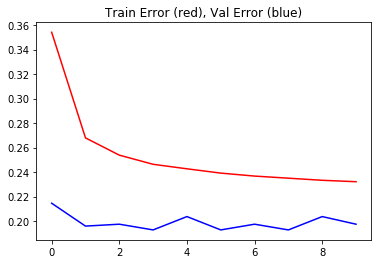

In [59]:
metrics = []
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=NUMBER_EPOCHS)

f.close()
v.close()
torch.save(model, "Model_" + str(MODELNO) + ".pt")

def training_plot(metrics):
    plt.figure(1)
    plt.plot([m.val_error for m in metrics], 'b')
    plt.plot([m.train_error for m in metrics], 'r')
    plt.title('Train Error (red), Val Error (blue)')
    plt.savefig('Model_' + str(MODELNO) + '.png')

training_plot(metrics)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [62]:
cuda_mtx = embedding_mtx.cuda()

RuntimeError: ignored